# Install Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Following are the required libraries for this notebook
! pip install textstat -q
! pip install lexical-diversity -q
! pip install spacy -q
! python -m spacy download en_core_web_sm -q
! pip install vaderSentiment -q
! pip install transformers -q

!python -m spacy download en_core_web_lg -q

! nvidia-smi 

!pip install transformers -q
!pip install nltk
!pip install pandarallel 
!pip install annoy -q
!pip install psutil -q

     |████████████████████████████████| 105 kB 32.1 MB/s 
     |████████████████████████████████| 2.0 MB 67.4 MB/s 
     |████████████████████████████████| 117 kB 27.5 MB/s 
     |████████████████████████████████| 12.0 MB 22.8 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 125 kB 21.5 MB/s 
     |████████████████████████████████| 4.0 MB 29.9 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 60.0 MB/s 
     |████████████████████████████████| 596 kB 52.3 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
     |████████████████████████████████| 827.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

  Created wheel for

In [ ]:
%%capture
# importing the necessary libraries
import textstat
import re

import pandas as pd
import numpy as np
import torch 
import multiprocessing as mp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import nltk
nltk.download("punkt")

import string
import pickle
from lexical_diversity import lex_div as ld

import spacy
from spacy.matcher import Matcher
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp_tagger = spacy.load('en_core_web_sm')
nlp_tagger.disable_pipes('parser', 'ner')

from spacy.lang.en import English
nlp_stop = English()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

from tqdm.auto import tqdm
tqdm.pandas()

import en_core_web_lg 
nlp=en_core_web_lg.load()
matcher = Matcher(nlp.vocab)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image 

from annoy import AnnoyIndex
import random

# Importing Libraries
from transformers import AutoTokenizer, AutoModel ,BertModel ,DistilBertTokenizerFast ,DistilBertForSequenceClassification, Trainer, EarlyStoppingCallback 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
import re  
import operator


import _pickle as cPickle

import psutil

workers = psutil.cpu_count()

from datetime import datetime
from collections import Counter  
from sklearn.metrics.pairwise import cosine_similarity

from gensim.models import Word2Vec    #Import gensim Word2Fec
from sklearn.decomposition import PCA #Grab PCA functions

import ast

from pandarallel import pandarallel

# from pandarallel.utils import progress_bars
# progress_bars.is_notebook_lab = lambda : True

pandarallel.initialize(progress_bar=True, nb_workers=workers, use_memory_fs=False)

from tqdm import trange 
from collections import Counter
from sklearn.metrics import classification_report ,accuracy_score, recall_score, precision_score, f1_score 


RANDOM_SEED_LANG = 42


# **Def Fun**

## Util

In [ ]:
# read and write model to pickle
def write_to_pickle(Pkl_File_path,model):
  with open(Pkl_File_path, 'wb') as file:  
      pickle.dump(model, file)

def read_pickle_model(path):
  with open(path, 'rb') as file:  
      return pickle.load(file)

In [ ]:
# remove urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def lower(text):
  return text.lower()
  
def remove_nonascii(sent):
  return "".join([i for i in sent if i.isascii()])

def remove_punctuations(text):
  # text = text.translate(str.maketrans('', ' ', string.punctuation))
  # return text

  res = re.sub(r'[^\w\s]', ' ', text)
  return res

def remove_num(text):
  return "".join([c for c in text if not c.isdigit()])

# remove multiple spaces
def remove_mul_space(text):
  return " ".join(text.split())

def clean_emotion(text):
  text = remove_urls(text)
  text = remove_nonascii(text)
  text = remove_punctuations(text)
  text = remove_num(text)
  text = remove_mul_space(text)
  return text

def clean_lexicon(text):
  
  text = lower(text)
  text = remove_urls(text)
  text = remove_nonascii(text)
  # text = remove_punctuations(text)
  # text = remove_num(text)
  text = remove_mul_space(text)

  return text

def clean_lang(text):
  
  text = remove_urls(text)
  text = remove_nonascii(text)
  text = remove_mul_space(text)
  return text

In [ ]:
# mapping of the labels to 0,1 
def label_map(x): 
  if x in ['true', 'mostly-true', 'half-true', 'real', 'Real', 0, 'REAL']:
    return 0
  elif x in ['false', 'pants-fire', 'barely-true', 'fake', 'Fake', 1, 'FAKE']:
    return 1
  else:return x

In [ ]:
def normalize(dataFrame,features , parameterDict={}):
  dataframe=dataFrame.copy()
  normDict={}
  for column in dataframe[features].columns.tolist():
    Q1=dataframe[column].quantile(0.25)
    Q3=dataframe[column].quantile(0.75)

    IQR=(Q3-Q1)
    minV=Q1 - 1.5*IQR
    maxV=Q3 + 1.5*IQR

    if (bool(parameterDict)):
      minV = parameterDict[column]["minV"]
      maxV = parameterDict[column]["maxV"]
      # print("using parameterDict")


    temp=dataframe[column].copy()
  
    if ( column not in ["qn_symbol_per_sentence" , "num_exclamation_per_sentence" ,"lexical_diversity" ,"url_count_per_sentence"] ) :
      dataframe[column]=dataframe[column].apply(lambda x:minV if x< minV else maxV if x>maxV else x)

      mean = dataframe[column].mean()
      std  = dataframe[column].std() 
      if (bool(parameterDict)):
        mean = parameterDict[column]["mean"]
        std = parameterDict[column]["std"]
        # print("using parameterDict")

      try:
        dataframe[column]=dataframe[column].apply(lambda x:  (x-mean)/std )
      except:
        print(column) 

    else:
      dataframe[column]=dataframe[column].apply(lambda x : 1 if x>0 else 0)
      mean = dataframe[column].mean()
      std  = dataframe[column].std() 
      # print("col",column)

    
    summaryDict={"Q1":Q1,"Q3":Q3,"IQR":IQR,"minV":minV,"maxV":maxV,"mean":mean,"std":std}
    normDict[column]=summaryDict
  return dataframe ,normDict

## Semantic

### **1) Quantity**

Quantity includes the following features,


*   Number of characters
*   Number of words
*   Number of Noun Phrases
*   Number of sentences
*   Number of paragraphs

Out of the above features, we are only interested in **characters, words and sentences**.

#### **1.1) Number of characters**

Following is the function to calculate the number of characters in a text.

In [ ]:
def num_chars(text):
  return len(text)

In [ ]:
def url_count(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    urls=re.findall(url_pattern,text)
    return len(urls)

In [ ]:
# remove urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:
def remove_nonascii(sent):
  return " ".join(("".join([i for i in sent if i.isascii()])).split())

In [ ]:
def get_no_of_qn_marks(text,percentage=False):
  return text.count("?")/len(text) if percentage else text.count("?")

#### **1.2) Number of words**

This function calculates the number of words in the text, **excluding the punctuations**.

In [ ]:
def num_words(text):
  return textstat.lexicon_count(text, removepunct=True)

#### **1.3) Number of sentences**

This function calculates the number of sentences in the text.

In [ ]:
def num_sentences(text):
  return textstat.sentence_count(text)

### **2) Complexity**

Complexity includes the following features,

*   Average number of characters per word
*   Average number of words per sentence
*   Average number of clauses per sentence
*   Average number of punctuations per sentence

#### **2.1) Average number of words per sentence**

The following function calculates the average number of words per sentence, i.e. (number of words/number of sentences)



In [ ]:
# This function uses functions defined in the previous section.
def words_per_sentence(text):
  return float(num_words(text))/num_sentences(text)

#### **2.2) Average number of characters per word**

The function calculates the number of characters per word.

In [ ]:
def characters_per_word(text):
  tokens = nltk.word_tokenize(text)
  nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
  filtered = [w for w in tokens if nonPunct.match(w)]
  return float(sum(map(len, filtered))) / len(filtered) if len(filtered)>0 else 0

#### **2.3) Average number of punctuations per sentence**

This function calculates the average number of punctuations per sentence.

In [ ]:
def punctuations_per_sentence(text):
  punc_count = sum([1 if char in string.punctuation else 0 for char in text])
  return punc_count / float(num_sentences(text))

### **3) Sentiment**

Sentiment includes the following features,

*  Percentage of Positive words
*  Percentage of Negative words
*  Number of Exclamation marks
*  Content Sentiment Polarity
*  Percentage of Anxiety/angry/sadness words

#### **3.1) Percentage of Positive words**

This function calculates the amount of postive words in the sentence as a percentage.

The function uses a corpus comparison method, the corpus is from, **Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews.", Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, Washington, USA.** 

In [ ]:
# # First we read the word list from drive
# with open("/content/drive/Shareddrives/FYP - knk/word_lists/positive_words.txt") as f:
#     positive_words = f.readlines()
# # you may also want to remove whitespace characters like `\n` at the end of each line
# positive_words = [x.strip() for x in positive_words]

# def positive(text):
#   tokens = nltk.word_tokenize(text)
#   nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
#   filtered = [w for w in tokens if nonPunct.match(w)]

#   count = 0
#   for word in filtered:
#     if word in positive_words:
#       count+=1

#   return (float(count)/len(filtered))*100  if len(filtered)>0 else 0

#### **3.2) Percentage of Negative words**

This function calculates the amount of negative words in the sentence as a percentage.

The function uses a corpus comparison method, the corpus is from, **Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews.", Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, Washington, USA.** 

In [ ]:
# # First we read the word list from drive 
# with open("/content/drive/Shareddrives/FYP - knk/word_lists/negative_words.txt" ,encoding="utf-8" ,  errors="ignore") as f:
#     negative_words = f.readlines()
# # you may also want to remove whitespace characters like `\n` at the end of each line
# negative_words = [x.strip() for x in negative_words]

# def negative(text):
#   tokens = nltk.word_tokenize(text)
#   nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
#   filtered = [w for w in tokens if nonPunct.match(w)]

#   count = 0
#   for word in filtered:
#     if word in negative_words:
#       count+=1

#   return (float(count)/len(filtered))*100  if len(filtered)>0 else 0

#### **3.3) Number of exclamation marks**

This function calculates the number of exclamation marks in the text

In [ ]:
def num_exclamation(text):
  tokens = nltk.word_tokenize(text)
  return len([w for w in tokens if w == "!"])

#### **3.4) Content Sentiment Polarity**

This is calculated using [VaderSentiment](https://github.com/cjhutto/vaderSentiment).

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

In [ ]:
def get_sentiment_polarity(text):
  vader_scores = sentiment_analyzer.polarity_scores(text)
  return vader_scores['compound'] # Outputs something like this {'pos': 0.094, 'compound': -0.7042, 'neu': 0.579, 'neg': 0.327}

#### **4) Diversity**

Diversity includes the following features,



*   Lexical diversity
*   Content word diversity
*   Redundancy
*   Unique Nouns/ Verbs/ Adjectives/ Adverbs



#### **4.1) Lexical Diversity**

This function calculates the **TTR** - TTR is the ratio obtained by dividing the types (the total number of different words) occurring in a text or utterance by its tokens (the total number of words).

This function is written using the **pypi lexical-diversity**.

In [ ]:
'''
Lemmatize is by default set to False, but if we want to lemmatize we could set 
that to True.

The lemmatizer which is not part of speech specific ('run' as a noun and 'run' 
as a verb are treated as the same word). However, it is likely better to use a 
part of speech sensitive lemmatizer (e.g., using spaCy).
'''

def lexical_diversity(text, lemmatize = False):
  tokens = ld.flemmatize(text) if lemmatize else ld.tokenize(text)
  return ld.ttr(tokens) * 100

#### **4.2) Content word diversity and Redundancy(Function words)**

In [ ]:
def content_word_diversity_and_redundancy(text):

  text = re.sub(r'[^\w\s]', '', text)
  doc = nlp_stop(text)

  # Create list of word tokens
  token_list = []
  for token in doc:
      token_list.append(token.text)

  # Create list of word tokens after removing stopwords
  content_words, function_words =[], []
  for word in token_list:
      lexeme = nlp_stop.vocab[word]
      if lexeme.is_stop == False:
          content_words.append(word) 
      else:
          function_words.append(word)
  
  output = {
      'content_word_diversity': (float(len(list(set(content_words)))) / num_words(text)) * 100  if num_words(text)>0 else 0 ,
      'redundancy': (float(len(list(set(function_words)))) / num_words(text)) * 100 if num_words(text)>0 else 0 ,
  }
  
  return output

#### **4.3) Percentage of unique nouns/verbs/adjectives/adverbs**

This function calculates the percentage of unique nouns, verbs, adjectives and adverbs and returns the results as a list.

In [ ]:
def nvaa(text):
  # Regular expression to take out the punctuations
  text = re.sub(r'[^\w\s]', '', text)

  doc = nlp_tagger(text)

  pos_tags = {
      'NOUN': [],
      'VERB': [],
      'ADJ': [],
      'ADV': [],
  }

  keys = pos_tags.keys()

  # Iterate over the tokens
  for token in doc:
      pos = token.pos_
      if pos in keys:
        pos_tags[pos].append(token.text)
  # print(pos_tags)

  output = {
      'NOUN': 0,
      'VERB': 0,
      'ADJ': 0,
      'ADV': 0
  }

  for key in output.keys():
    output[key] = (len(list(set(pos_tags[key]))) / float(num_words(text))) * 100 if num_words(text)>0 else 0

  return output

### **6) uncertainity**

#### model verbs

In [ ]:
def to_nlp_tags(text):
  doc=nlp(text)
  sents=list(doc.sents)
  return pd.Series([doc,sents], index=['doc', 'sents'])    
  get_MD_verb_count(doc,sents)

In [ ]:
# for spacy need to install below
# !python -m spacy download en_core_web_lg
# import en_core_web_lg 
# nlp=en_core_web_lg.load()
# matcher = Matcher(nlp.vocab)

def get_MD_verb_count(doc ,sents,percentage=True,lib="spacy"):
  if lib=="spacy":
    # doc=nlp(text)
    # sents = list(doc.sents)
    # dep=[]
    # tag=[]
    count=0
    for sent in sents:
      for token in sent:
        # dep.append(token.dep_)
        # tag.append(token.tag_)
        if token.tag_ =="MD":
          count=count+1

    return count/len(sents) if percentage else count

  else: ## nltk
    tok=nltk.word_tokenize(text.lower())
    postags=nltk.pos_tag(tok)
    return len([i[0] for i in postags if i[1]=="MD"])/len(tok) if percentage else len([i[0] for i in postags if i[1]=="MD"])

# text="You must obey the rules, or you will get puniched"
# get_MD_verb_count(to_nlp_tags(text))

##### qn marks

In [ ]:
# def get_no_of_qn_marks(text,percentage=False):
#   return text.count("?")/len(text) if percentage else text.count("?")

#### quantifiers

In [ ]:
def count_quantifiers(doc,sents ,nlp=nlp ,matcher=matcher,percentage=True):
  # doc=nlp(text)
  # sents = list(doc.sents)
  # dep=[]
  # tag=[]
  count=0
  for sent in sents:
    for token in sent:
      # dep.append(token.dep_)
      # tag.append(token.tag_)
      if token.tag_ =="CD":
        # print(token)
        count=count+1

  return count/len(sents) if percentage else count

In [ ]:
# count_quantifiers("thirteen fifteen sixty three few many year old ")

### **7) non_immediacy**

In [ ]:
# run below commented section to downlaod spacy corpous 
# !python -m spacy download en_core_web_lg
# https://gist.github.com/armsp/30c2c1e19a0f1660944303cf079f831a
# import en_core_web_lg 
# nlp=en_core_web_lg.load()
# matcher = Matcher(nlp.vocab)
def count_passive(doc ,nlp=nlp ,matcher=matcher):
  # doc = nlp(text)
  # sents = list(doc.sents)
  # print("Number of Sentences = ",len(sents))
  # for sent in doc.sents:
  #   for token in sent:
  #       print(token.dep_,token.tag_, end = " ")
  #   print()
  passive_rule = [{'DEP':'nsubjpass'},{'DEP':'aux','OP':'*'},{'DEP':'auxpass'},{'TAG':'VBN'}]
  matcher.add('Passive',None,passive_rule)
  matches = matcher(doc)
  # print("Number of PASSIVE Sentences = " , len(matches))
  return len(matches)

In [ ]:
def non_immediacy(doc,sents):
  FPS = ["i"	,"me",	"my"	,"mine",	"myself"]  # first person singular
  FPP = ["we"	,"us",	"our",	"ours",	"ourselves"] #first person pluran
  SPS =["you",	"your",	"yours",	"yourself"] # second person singular
  # SPP =["you",	"your",	"yours",	"yourself"] # second person plural
  TPS = ["he",	"him",	"his",	"himself" ,"she"	,"her",	"hers"	,"herself","it"	,"its",	"itself"]  # third person singular
  TPP=["they",	"them",	"their"	,"theirs"	,"themselves"] # third person plural

  # doc=nlp(text.lower())
  # sents=list(doc.sents)

  dic={"fps":0,"fpp":0,"sps":0,"spp":0,"tps":0 ,"tpp":0}
  qt=False
  qtCount=0
  for sent in sents:
    for token in sent :
      strVal=token.string.lower()
      if (token.tag_=="``"):
        if qt:
          qtCount+=1
        qt=!qt
      if  strVal in FPS :
        dic["fps"]+=1
      elif strVal in FPP:
        dic["fpp"]+=1
      elif strVal in SPS:
        dic["sps"]+=1
      elif strVal in TPS:
        dic["tps"]+=1
      elif strVal in TPP:
        dic["tpp"]+=1
  dic["passive_count"]=count_passive(doc)
  dic["sentence_count"]=len(sents)
  dic["quated_text"]=qtCount
  return dic
  # return pd.Series([dic["passive_count"],dic["sentence_count"],dic["quated_text"],dic["fps"],dic["fpp"],dic["sps"],dic["tps"],dic["tpp"]], index=['passive_count', 'sentence_count', 'quated_text','fps','fpp','sps','tps','tpp'])

In [ ]:
def uncertinity_and_non_immediacy(text):
  doc =nlp(text)
  sents=list(doc.sents)

  model_verbs=get_MD_verb_count(doc,sents)
  quantifiers=count_quantifiers(doc,sents)

  output=non_immediacy(doc,sents)
  output["model_verbs"]=model_verbs
  output["quantifiers"]=quantifiers

  return pd.Series(data = output)


## Emotion

In [ ]:
Emotion_features= [
                    #  'highest_eight_label', 
                    'anger', 
                    'anticipation',
                    'disgust', 
                    'fear',
                    'joy', 
                    'sadness', 
                    'surprise', 
                    'trust'
                    ]

In [ ]:
df_emotion = pd.read_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/NRC-Modified-Final.csv")

df_emotion['embedding'] = [ast.literal_eval(i) for i in df_emotion['embedding'].values.tolist()]
# print(df_emotion.head())
# print(df_emotion.columns)

In [ ]:
# print(df_emotion.groupby('emotion').count())
# print(df_emotion.groupby('emotion').sum())
# df_emotion.info()

In [ ]:
# len(df_emotion['embedding'][0])

In [ ]:
f_emotion = 768
t_emotion = AnnoyIndex(f_emotion, 'angular')  # Length of item vector that will be indexed

# super fast, will just mmap the file
# t.load(r'/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/Aug - 4th week/angular_nrc_embedding_space_V3.ann') 
t_emotion.load(r'/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/NRC-Modified-Final.ann') 

True

In [ ]:
# t_emotion.get_n_items()

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling_emotion(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    # print('ime',input_mask_expanded)
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    # print('se',sum_embeddings)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
tokenizer_emotion = AutoTokenizer.from_pretrained("/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/go_model")
model_emotion = AutoModel.from_pretrained("/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/go_model")
model_emotion=model_emotion.to(device)

In [ ]:
def get_mean_pooling_emb_emotion(sentences):
  encoded_input = tokenizer_emotion(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt')
  encoded_input=encoded_input.to(device)
  #Compute token embeddings
  with torch.no_grad():
      model_output = model_emotion(**encoded_input)

  sentence_embeddings_raw = mean_pooling_emotion(model_output, encoded_input['attention_mask'])
  sentence_embeddings = sentence_embeddings_raw.tolist()

  return sentence_embeddings[0]

In [ ]:
def calculate_scores_emotion(neaarest_neighbs_words,neaarest_neighbs_labels,neaarest_neighbs_distance,neaarest_neighbs_intensity_score):
  score_dict_emotion = {
              'anticipation':0,
              'anger':0,
              'fear':0,
              'sadness':0,
              'trust':0,
              'joy':0,
              'surprise':0,
              'disgust':0
              }

  #Scoring Mechanism
  for i in range(0,len(neaarest_neighbs_words)):
    distance = 0
    if neaarest_neighbs_distance[i] == 0 :
      distance = 1
    else :
      distance = (1/neaarest_neighbs_distance[i])
    
    score = (distance*(neaarest_neighbs_intensity_score[i]))  

    score_dict_emotion[neaarest_neighbs_labels[i]]=score_dict_emotion[neaarest_neighbs_labels[i]]+score


  #Normalising Mechanism
  normalized_score_dict = score_dict_emotion.copy()
  # for k in score_dict.keys():
  #   if score_dict[k] ==0:
  #     continue
  #     # del normalized_score_dict[k]
  #   else:
  #     normalized_score_dict[k]
  #     # normalized_score_dict[k] = round((score_dict[k]/score_max),3)

  return normalized_score_dict

In [ ]:
def get_nearest_neighbours_emotion(index):
    tuples = []
    
    embeding = df_emotion['embedding'][index]
    # sentence_tokens = dff['text'][index].split(' ')


    # for i,row_e in df.iterrows():
        
    #     dis = cosine_similarity([row_e['embedding']], [embeding])
    #     # print([row_e['tokens'],row_d['tokens'],dis])
    #     tuples.append([row_e['word'],row_e['emotion'],dis,row_e['embedding'],row_e['emotion-intensity-score']])

    indexes, distances = t_emotion.get_nns_by_vector(embeding, 50, include_distances=True)
    for i in range(len(indexes)):
      tuples.append([df_emotion['word'][indexes[i]],df_emotion['emotion'][indexes[i]],distances[i],df_emotion['embedding'][indexes[i]],df_emotion['emotion-intensity-score'][indexes[i]]
                    #  df['Positive'][indexes[i]],df['Negative'][indexes[i]]
                     ])
    # print(indexes)
    # print(distances)
    # print(tuples)
    
    s_tup = sorted(tuples, key=lambda x: x[2])#sort tuples based on the cosine distance
    neaarest_neighbs_words = []
    neaarest_neighbs_embs = []
    neaarest_neighbs_labels = []
    neaarest_neighbs_distance = []
    neaarest_neighbs_intensity_score = []
    for i,m in enumerate(s_tup[::-1]):
        # print(m)
        if(i<50):#getting the nearest 50 neighbours
            neaarest_neighbs_words.append(m[0])
            neaarest_neighbs_embs.append(m[3])
            neaarest_neighbs_labels.append(m[1])
            # distance = m[2].tolist()[0][0]
            distance = m[2]
            neaarest_neighbs_distance.append(distance)
            neaarest_neighbs_intensity_score.append(m[4])

    n_score_dict = calculate_scores_emotion(neaarest_neighbs_words,neaarest_neighbs_labels,neaarest_neighbs_distance,neaarest_neighbs_intensity_score)
    
    neighbour_output = [n_score_dict,{'words':neaarest_neighbs_words,'embs':neaarest_neighbs_embs,'labels':neaarest_neighbs_labels}]
    normalized_score_dict = neighbour_output[0]
  
    # for key in normalized_score_dict:    
    #   normalized_score_dict[key] = round(normalized_score_dict[key],4)

    normalized_score_dict = {k: round(v,3) for k, v in sorted(normalized_score_dict.items(), key=lambda item: item[1])}
    # print(normalized_score_dict)
    return normalized_score_dict

In [ ]:
def dict_to_result_emotion(emotion_dict):
  if (all(value == 0 for value in emotion_dict.values())):
    highest_8 = None
  else:
    highest_8 = max(emotion_dict.items(), key=operator.itemgetter(1))[0]
  return highest_8

# result = emotion_candidates_recognition('That was good',1)
# x = dict_to_result(result)

## Lexicon 

In [ ]:
LexMod_Features=   [
                    #  'fake_score', 
                    # 'true_score', 
                     'fake_score1', 
                    'true_score1', 
                     'fake_score2', 
                    'true_score2', 
                    # 'common_score'
                    ]

In [ ]:
f_lexicon = 768
ann = AnnoyIndex(f_lexicon, 'angular')  
ann.load(r'/content/drive/Shareddrives/[FYP] Fake News Detection/Lexicons/Lexi-Annoy-31-02-2022.ann') 

lexicon = pd.read_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Lexicons/Lexicon_df.csv")

In [ ]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling_lexicon(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer_lexicon = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# model = AutoModel.from_pretrained(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/Fine tuning WELFake/Fine-tuned Model Improved")
model_lexicon = AutoModel.from_pretrained(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/Fine tuning WELFake/Fine-tuned Model Improved V3")
model_lexicon = model_lexicon.to(device)

# Generate Embeddings - This function returns the embeddings of all the texts
def generate_embeddings_lexicon(sentences, model, tokenizer):

  encoded_input = tokenizer_lexicon(sentences, padding=True, truncation=True, return_tensors='pt').to(device)

  with torch.no_grad():
    model_output = model_lexicon(**encoded_input)

  sentence_embeddings = mean_pooling_lexicon(model_output, encoded_input['attention_mask'])

  return sentence_embeddings.detach().cpu().numpy().tolist()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Lang

In [ ]:
Embed_features = ["embd_true","embd_fake"]

In [ ]:
tokenizer_lang = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model_lang = DistilBertForSequenceClassification.from_pretrained(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kogul_Language_Modelling/Fine tuning WELFake/Fine-tuned Model Improved V3", num_labels=2)
trainer_lang = Trainer(model_lang)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# def compute_metrics(p):
#     pred, labels = p
#     pred = np.argmax(pred, axis=1)

#     accuracy = accuracy_score(y_true=labels, y_pred=pred)
#     recall = recall_score(y_true=labels, y_pred=pred)
#     precision = precision_score(y_true=labels, y_pred=pred)
#     f1 = f1_score(y_true=labels, y_pred=pred)

#     return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


## Single Funtion to Extract features

## funtion to extract all semantic features 

In [ ]:
# set All_features value to be used by the models 
Semantic_features= [
                    # 'url_count', #
                    # 'qn_symbol', #
                    # 'num_chars', #
                    # 'num_words', #
                    # 'num_sentences', #
                    # 'num_exclamation', #
                    'words_per_sentence',  
                    'characters_per_word',
                    'punctuations_per_sentence', 
                    'get_sentiment_polarity',  
                    'lexical_diversity',
                    'content_word_diversity',
                    'redundancy',
                    'noun',
                    'verb',
                    'adj',
                    'adv',
                    "qn_symbol_per_sentence",
                    "num_exclamation_per_sentence",
                    "url_count_per_sentence"
                    ]

In [ ]:
def get_semantic_features(dataframe,textColumn="text"):
  df = dataframe.copy(deep=True)[[textColumn]]
  df["url_count"] = df["text"].apply(url_count)
  df["text_cleaned"] = df["text"].apply(remove_urls)
  df["text_cleaned"] = df["text_cleaned"].apply(remove_nonascii)
  df["qn_symbol"]=df["text"].apply(get_no_of_qn_marks)
  df["num_chars"]=df["text"].apply(num_chars)
  df["num_words"]=df["text"].apply(num_words)
  df["num_sentences"]=df["text"].apply(num_sentences)
  df["words_per_sentence"]=df["text"].apply(words_per_sentence)
  df["characters_per_word"]=df["text"].apply(characters_per_word)
  df["punctuations_per_sentence"]=df["text"].apply(punctuations_per_sentence)
  df["num_exclamation"]=df["text"].apply(num_exclamation)
  df["get_sentiment_polarity"]=df["text"].apply(get_sentiment_polarity)
  df["lexical_diversity"]=df["text"].apply(lexical_diversity)
  df["content_word_diversity_and_redundancy"]=df["text"].apply(content_word_diversity_and_redundancy)
  df["nvaa"]=df["text"].apply(nvaa) 
  df["content_word_diversity"]=df["content_word_diversity_and_redundancy"].apply(lambda x: x["content_word_diversity"])
  df["redundancy"]=df["content_word_diversity_and_redundancy"].apply(lambda x: x["redundancy"])
  df["noun"]=df["nvaa"].apply(lambda x: x["NOUN"])
  df["verb"]=df["nvaa"].apply(lambda x: x["VERB"])
  df["adj"]=df["nvaa"].apply(lambda x: x["ADJ"])
  df["adv"]=df["nvaa"].apply(lambda x: x["ADV"])
  df["qn_symbol_per_sentence"]=df["qn_symbol"]/df["num_sentences"]
  df["num_exclamation_per_sentence"]=df["num_exclamation"]/df["num_sentences"]
  df["url_count_per_sentence"]=df["url_count"]/df["num_sentences"]
  return df[Semantic_features]

## single function to extract emotion feature

In [ ]:
def get_emotion_features(dataframe,textColumn="text"):
  df = dataframe.copy(deep=True)[[textColumn]]
  df['text'] = df[textColumn].apply(lower)

  df['text'] = df['text'].apply(clean_emotion)
  df = df.reset_index(drop=True)
  df['embedding']  = df['text'].apply(get_mean_pooling_emb_emotion)

  col_names =['text','embedding']
  df = df[col_names]
  df['index'] = df.index

  df['emotion_score_dict'] = df['index'].apply(get_nearest_neighbours_emotion)
  df['highest_eight_label'] = df['emotion_score_dict'].apply(dict_to_result_emotion)
  eight_label = df['emotion_score_dict'].to_list()

  df["anger"]=[i["anger"] for i in eight_label]
  df["anticipation"]=[i["anticipation"] for i in eight_label]
  df["disgust"]=[i["disgust"] for i in eight_label]
  df["fear"]=[i["fear"] for i in eight_label]
  df["joy"]=[i["joy"] for i in eight_label]
  df["sadness"]=[i["sadness"] for i in eight_label]
  df["surprise"]=[i["surprise"] for i in eight_label]
  df["trust"]=[i["trust"] for i in eight_label]
  return df[Emotion_features].copy(deep=True)

## single funtion to extract lexicon features 

In [ ]:
def get_scores(embedding):
  true, fake = 0, 0
  total_fake_doc, total_fake_occ = 0, 0
  total_true_doc, total_true_occ = 0, 0

  indexes, distances = ann.get_nns_by_vector(embedding, 100, include_distances=True, search_k=-1)
  
  count_true, count_fake = 0, 0

  for j in range(len(indexes)):

    fake_doc, true_doc = lexicon['fake_doc_score'][indexes[j]], lexicon['true_doc_score'][indexes[j]]
    fake_occ, true_occ = lexicon['fake_occ_score'][indexes[j]], lexicon['true_occ_score'][indexes[j]]
    
    fake_occ_this, true_occ_this = fake_occ * ((fake_occ) / (fake_occ + true_occ)), true_occ * ((true_occ) / (fake_occ + true_occ))
    fake_doc_this, true_doc_this = fake_doc * ((fake_doc) / (fake_doc + true_doc)), true_doc * ((true_doc) / (fake_doc + true_doc))

    total_fake_occ += fake_occ_this
    total_fake_doc += fake_doc_this
    
    total_true_occ += true_occ_this
    total_true_doc += true_doc_this
    

    if fake_doc_this != 0 and true_doc_this != 0:
      fake += (fake_occ_this / fake_doc_this) / distances[j]
      true += (true_occ_this / true_doc_this) / distances[j]

    elif fake_doc_this == 0 :
      count_true += 1
      true += (true_occ_this / true_doc_this) / (distances[j])

    else:
      count_fake += 1
      fake += (fake_occ_this / fake_doc_this) / (distances[j])

  return [fake*100/(fake+true), true*100/(fake+true), total_fake_occ, total_fake_doc, total_true_occ, total_true_doc]

def get_lexicon_score(dataframe,textColumn="text"):
  df = dataframe.copy(deep=True)[[textColumn]]
  df['text'] = df[textColumn]
  df["text"] = df['text'].apply(clean_lexicon)
  all_words = df['text'].tolist()
  all_words_embeddings = []

  EMBEDDING_RANGE = 200

  for i in trange(0, len(all_words), EMBEDDING_RANGE):
    all_words_embeddings.extend(generate_embeddings_lexicon(all_words[i:i+EMBEDDING_RANGE], model_lexicon, tokenizer_lexicon))

  df['embedding'] = all_words_embeddings

  df["scores"] = df["embedding"].apply(get_scores)
  # df["scores"]=df["scores"].apply(lambda x : list(map(np.float64, x.strip('][').replace('"', '').replace("'","").replace(" ","").split(','))))

  # df["fake_score"]=df["scores"].apply(lambda x:x[0])
  # df["true_score"]=df["scores"].apply(lambda x:x[1])

  df["fake_score1"]=df["scores"].apply(lambda x:x[2])
  df["true_score1"]=df["scores"].apply(lambda x:x[3])

  df["fake_score2"]=df["scores"].apply(lambda x:x[4])
  df["true_score2"]=df["scores"].apply(lambda x:x[5])
  return df[LexMod_Features]

## SIngle funtion to extract Lang fetures

In [ ]:
def get_lang_features(dataframe,textColumn="text"):
  df = dataframe.copy(deep=True)[[textColumn]] 

  df["text"]=df["text"].apply(clean_lang)
  texts=df["text"].to_list()

  encodings_lang = tokenizer_lang(texts, truncation=True, padding=True)
  dataset_lang = Dataset(encodings_lang)
  raw_pred_lang, _, _ = trainer_lang.predict(dataset_lang)

  df["embd_true"]=raw_pred_lang[:,1]
  df["embd_fake"]=raw_pred_lang[:,0]

  return df[Embed_features]


#Example

In [ ]:
#@title Normalization Parameters
param={'adj': {'IQR': 3.920274651354121,
  'Q1': 3.2225824915030215,
  'Q3': 7.142857142857142,
  'maxV': 13.023269119888324,
  'mean': 5.253355977159745,
  'minV': -2.6578294855281603,
  'std': 3.6516322405515624},
 'adv': {'IQR': 4.266580478345184,
  'Q1': 0.0,
  'Q3': 4.266580478345184,
  'maxV': 10.666451195862962,
  'mean': 2.863691454355184,
  'minV': -6.399870717517777,
  'std': 2.8664873514992695},
 'anger': {'IQR': 6.551,
  'Q1': 3.754,
  'Q3': 10.305,
  'maxV': 20.1315,
  'mean': 7.678782850500116,
  'minV': -6.0725,
  'std': 5.359614312959114},
 'anticipation': {'IQR': 3.431,
  'Q1': 0.692,
  'Q3': 4.123,
  'maxV': 9.2695,
  'mean': 2.780320162759851,
  'minV': -4.4544999999999995,
  'std': 2.547901031179789},
 'characters_per_word': {'IQR': 0.5774664763628214,
  'Q1': 4.687203712100914,
  'Q3': 5.264670188463735,
  'maxV': 6.130869903007968,
  'mean': 5.00141622763443,
  'minV': 3.8210039975566814,
  'std': 0.5114419055117717},
 'content_word_diversity': {'IQR': 24.203069657615117,
  'Q1': 40.082644628099175,
  'Q3': 64.28571428571429,
  'maxV': 100.59031877213697,
  'mean': 53.39967734939156,
  'minV': 3.778040141676499,
  'std': 16.762174829428236},
 'disgust': {'IQR': 1.8287499999999999,
  'Q1': 0.53525,
  'Q3': 2.364,
  'maxV': 5.107125,
  'mean': 1.6311068963530888,
  'minV': -2.207875,
  'std': 1.4380651382957068},
 'fear': {'IQR': 3.396,
  'Q1': 2.242,
  'Q3': 5.638,
  'maxV': 10.732,
  'mean': 4.276762929680442,
  'minV': -2.8519999999999994,
  'std': 2.7786040618661993},
 'get_sentiment_polarity': {'IQR': 1.2363,
  'Q1': -0.5994,
  'Q3': 0.6369,
  'maxV': 2.4913499999999997,
  'mean': 0.020566418441944345,
  'minV': -2.45385,
  'std': 0.6749796812853233},
 'joy': {'IQR': 4.21775,
  'Q1': 1.954,
  'Q3': 6.171749999999999,
  'maxV': 12.498375,
  'mean': 4.531459704068525,
  'minV': -4.372625,
  'std': 3.4955052730211746},
 'lexical_diversity': {'IQR': 43.94904458598726,
  'Q1': 56.05095541401274,
  'Q3': 100.0,
  'maxV': 165.9235668789809,
  'mean': 1.0,
  'minV': -9.872611464968152,
  'std': 0.0},
 'noun': {'IQR': 6.794754161237776,
  'Q1': 12.099255055352085,
  'Q3': 18.89400921658986,
  'maxV': 29.086140458446526,
  'mean': 15.572582456336178,
  'minV': 1.9071238134954207,
  'std': 6.7761109560755335},
 'num_exclamation_per_sentence': {'IQR': 0.0,
  'Q1': 0.0,
  'Q3': 0.0,
  'maxV': 0.0,
  'mean': 0.11770250738389995,
  'minV': 0.0,
  'std': 0.3222572184165985},
 'punctuations_per_sentence': {'IQR': 3.25,
  'Q1': 2.0,
  'Q3': 5.25,
  'maxV': 10.125,
  'mean': 3.886805705834294,
  'minV': -2.875,
  'std': 2.6536563960566713},
 'qn_symbol_per_sentence': {'IQR': 0.0,
  'Q1': 0.0,
  'Q3': 0.0,
  'maxV': 0.0,
  'mean': 0.18291124656989044,
  'minV': 0.0,
  'std': 0.38659576794873474},
 'redundancy': {'IQR': 17.4074074074074,
  'Q1': 15.925925925925927,
  'Q3': 33.33333333333333,
  'maxV': 59.44444444444443,
  'mean': 24.75348232770155,
  'minV': -10.185185185185173,
  'std': 11.967660265159019},
 'sadness': {'IQR': 4.0,
  'Q1': 1.101,
  'Q3': 5.101,
  'maxV': 11.100999999999999,
  'mean': 3.5015443348206974,
  'minV': -4.899,
  'std': 3.0034404522555165},
 'surprise': {'IQR': 1.314,
  'Q1': 0.611,
  'Q3': 1.925,
  'maxV': 3.896,
  'mean': 1.321899285699221,
  'minV': -1.36,
  'std': 1.027441653041326},
 'trust': {'IQR': 6.59375,
  'Q1': 1.224,
  'Q3': 7.81775,
  'maxV': 17.708375,
  'mean': 5.213431108474932,
  'minV': -8.666625,
  'std': 4.872724829591072},
 'url_count_per_sentence': {'IQR': 0.0,
  'Q1': 0.0,
  'Q3': 0.0,
  'maxV': 0.0,
  'mean': 0.09614780368252372,
  'minV': 0.0,
  'std': 0.2947953760357282},
 'verb': {'IQR': 4.462204462204459,
  'Q1': 9.090909090909092,
  'Q3': 13.553113553113551,
  'maxV': 20.24642024642024,
  'mean': 11.391330328425516,
  'minV': 2.3976023976024026,
  'std': 4.453375512755936},
 'words_per_sentence': {'IQR': 22.0,
  'Q1': 13.0,
  'Q3': 35.0,
  'maxV': 68.0,
  'mean': 25.94187486735694,
  'minV': -20.0,
  'std': 15.493648314664558}}

In [ ]:
#@title Function to Extract and Normalize all the features
def extract_and_normalize(dff):
  # print("\n-------- Extrating Semantic Features --------\n")
  df_sem=get_semantic_features(dff)
  # display(df_sem.head())

  # print("\n-------- Extrating Emotion  Features --------\n")
  df_emo=get_emotion_features(dff)
  # display(df_emo.head())

  # print("\n-------- Extrating lexicon  Features --------\n")
  df_lex = get_lexicon_score(dff)
  # display(df_lex.head())

  # print("\n-------- Extrating language Features --------\n")
  df_lang = get_lang_features(dff)
  # display(df_lang.head())

  # print("\n------- Combining Extracted Features -------\n")
  df_before_norm=pd.concat([df_sem,df_emo,df_lex,df_lang],axis=1)

  # print("\n-------- Input Features : Before Normalization  --------\n")
  # display(df_before_norm.head())

  # print("\n-------- Standardizing Input Features  --------\n")
  df , p = normalize(df_before_norm,Semantic_features+Emotion_features,param)

  # print("\n-------- Input Features : After Normalization  --------\n")
  # display(df.head())

  return df , p

In [ ]:
#@title Load Model
All_features=Semantic_features + Emotion_features +LexMod_Features+Embed_features

voting_classifier_path="/content/drive/Shareddrives/[FYP] Fake News Detection/Final/Final_Voting_model_5_dataset/All_VotingClassifier_hard.pkl"
vc_model=read_pickle_model(voting_classifier_path)
estimators=vc_model.named_estimators_

ling_GNB_model=estimators["sementic_estimator"]
lang_KNN_model= estimators["lexP_embd_estimator"]
emo_GNB_model=estimators["emotion_estimator"]

When the coronavirus outbreak began, the Centers for Disease Control and Prevention listed cough, shortness of breath and fever as possible symptoms. Now, the organization is adding six new possible symptoms to its list, including headache, chills and loss of taste or smell.

The New York Times has published an article by popular author Kevin Roose in which he expresses his concern that half of Americans would refuse to take a coronavirus vaccine.  The vaccine, if it ever gets produced since there has never been one for any coronavirus including SARS, is likely to take 12-24 months according to experts.  In his article entitled What if we get a Covid-19 vaccine and half the country refuses to take it?, Roose laments the popularity of an anti-vaxxer video called Plandemic, which despite being censored numerous times by every major social media network has still been seen by millions of people.  Roose says that the urgency with which a vaccine will need to be produced will allow anti-vaxxers to claim it’s unsafe.  “Any promising Covid-19 vaccine is likely to be fast-tracked through the testing and approval process,” he writes. “It may not go through years of clinical trials and careful studies of possible long-term side effects, the way other drugs do. That could create an opening for anti-vaccine activists to claim that it is untested and dangerous, and to spin reasonable concerns about the vaccine into widespread, unfounded fears about its safety.”  The involvement of Bill Gates in the distribution of any vaccine will also fuel a backlash, according to Roose.  “If that’s the case, anti-vaccine activists, who have been crusading against these groups for years, will have plenty of material stockpiled to try to discredit them. They are already taking aim at Mr. Gates with baseless conspiracy theories claiming that he created and is trying to profit from the virus. These theories will be amplified, and the attempts to discredit leading virus research efforts will intensify as the vaccine nears.”  Finally, he asserts that it would be “a good idea” to make the vaccine mandatory if Americans want to fly or send their kids to certain schools, but that this “would play into some of the worst fears of the anti-vaccine movement” and create “a tangle of legal roadblocks and damaging publicity campaigns.”

In [ ]:
‘Fewer Covid-19 cases in hotter regions’ U Tejonmayam | TNN | Apr 26, 2020, 06:25 IST Researchers at IIT-M found that 90% of the total confirmed cases were recorded in regions with temperatures be... Read More CHENNAI: A team of researchers from IIT Madras has found that there is a lower incidence of Covid-19 in regions recording high temperatures.
The team, which did a statistical analysis of more than 1.07 lakh cases from 85 different locations in the most affected countries, found that 90% of the total confirmed cases were recorded in regions with temperatures between 3°C and 12°C.
On the surge in cases in Chennai, which records a maximum of 36°C, the researchers indicated that people’s adherence to lockdown measures and advice of medical experts also play an important role in bringing down cases.
Professor Sachin S Gunthe from IIT-M’s department of civil engineering said previous studies on other influenza viruses have shown that their survival period on certain surfaces may reduce when exposed to high temperatures or high UV index. “This study for coronavirus, however, is purely based on statistical evidences. There is no physiological evidence as yet to prove this fact. Nevertheless, if what we have seen in the study is true then if people follow the lockdown rules strictly and observe the advice of medical experts, we may come out of this crisis quicker than other nations,” he said.
The IIT-M study, published in Journal of Public Health, showed that an increase in the UV index, which is the strength of sunburn producing ultraviolet radiation, also correlated with a decrease in the number of cases. It led the researchers to suggest that artificial UV radiation could be one of the effective ways to sterilize builtup environments for reducing community spread. Rainfall, humidity and cloud cover have no effect on the virus, according to the statistical analysis.
The researchers took into account previous studies that showed influenza-causing viruses peak during cold temperatures and gradually subside as temperatures get warmer. Since people with Covid-19 mostly exhibit flu-like symptoms, the team expected coronavirus to show similar patterns, which is physiologically to be proven.
The researchers arrived at the results by preparing scatter plots or mathematical diagrams with the number of confirmed cases and the various meteorological parameters. Data on confirmed cases in cities, reported between February 2 and March 7 that contributed to 70% of the total number of cases in countries like China, South Korea, Italy, Iran, France, Germany, USA, Spain and Japan were plotted against weather parameters like maximum, minimum and average temperatures, UV index, precipitation, humidity and cloud cover.
The researchers said their results are preliminary and require a detailed physiological studies involving the confirmed cases.
Download The Times of India News App for Latest City News
Subscribe Start Your Daily Mornings with Times of India Newspaper! Order Now

INPUT TEXT IS : 
 For those in #Australia, just in case you’re wondering who owns the milk you drink. China company Mengniu Dairy owns the following brands: Dairy Farmers, Pura, Farmers Union, Masters, Moove, Dare, Vitasoy, Yoplait, Fruche, Divine Classic, YoGo, Big M, Berri, Just Juice, Daily Juice, King Island Dairy, South Cape, Tilba, Timboon, Tasmanian Heritage and Clover Creek,


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


0 0 [0] 0
True True True  ==>  True
Semantic Probablity :  [0.95 0.05] => True
languge model probablity :  [0.6 0.4] => True
Emotion probablity :  [0.71 0.29] => True
Final Label by Voting Classifier :  => True News


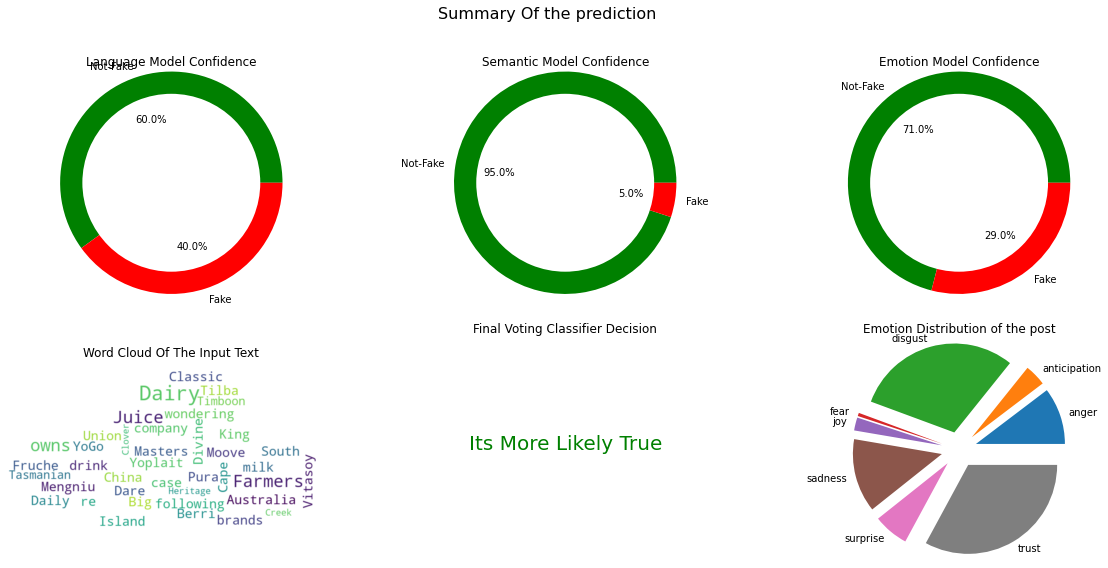

In [ ]:
#@title Paste Your text here { display-mode: "form" }
text = "For those in #Australia, just in case you\u2019re wondering who owns the milk you drink. China company Mengniu Dairy owns the following brands: Dairy Farmers, Pura, Farmers Union, Masters, Moove, Dare, Vitasoy, Yoplait, Fruche, Divine Classic, YoGo, Big M, Berri, Just Juice, Daily Juice, King Island Dairy, South Cape, Tilba, Timboon, Tasmanian Heritage and Clover Creek," #@param {type:"string"}
# text = "The pandemic sped up the shift to online shopping, and the continued growth of e-commerce sales will lead to more stores shutting down after the pandemic ends, UBS retail analysts predicted in a recent report. The report estimates that around 80,000 stores will close over the next five years. They also believe the number of US malls will also decline over the same period." #@param {type:"string"}

print("INPUT TEXT IS : \n",text)
d={"text":[text]}
dff = pd.DataFrame(data=d)
# dff["id"]=dff.index

df,p=extract_and_normalize(dff)

pred=vc_model.predict(df)

pred_ling=ling_GNB_model.predict(df)
pred_lang=lang_KNN_model.predict(df)
pred_emo=emo_GNB_model.predict(df)

pred_ling_prob=ling_GNB_model.predict_proba(df).round(decimals=2)
pred_lang_prob=lang_KNN_model.predict_proba(df).round(decimals=2)
pred_emo_prob=emo_GNB_model.predict_proba(df).round(decimals=2)

induvidual_model_output_and_vc_prediction=["Fake" if i else "True" for i in [pred_lang,pred_ling,pred_emo,pred]]
print(pred_lang[0],pred_ling[0],pred_emo,pred[0])
print(" ".join(induvidual_model_output_and_vc_prediction[:-1]) , " ==> " ,induvidual_model_output_and_vc_prediction[-1])
print("Semantic Probablity : " , pred_ling_prob[0]  ,"=> Fake" if pred_ling else "=> True")
print("languge model probablity : " ,pred_lang_prob[0],"=> Fake" if pred_lang else "=> True") 
print("Emotion probablity : " , pred_emo_prob[0],"=> Fake" if pred_emo else "=> True")
print("Final Label by Voting Classifier : " , "=> Fake News" if pred else "=> True News" )



# ==================== Summarizing ====================================================
# =====================================================================================
fig, axs = plt.subplots(2,3,figsize=(20,9))
fig.suptitle('Summary Of the prediction', fontsize=16)
# fig.tight_layout()

# --------------------------------- Language Model -------------------------------------
ax00=axs[0][0]
ax00.set_title('Language Model Confidence')
ax00.pie([pred_lang_prob[0][0],pred_lang_prob[0][1]] ,labels=["Not-Fake","Fake"],colors=["green","red"],radius=1.25,autopct='%1.1f%%')
ax00.pie([1],colors=["white"])

# --------------------------------- Semantic Model -------------------------------------
ax01=axs[0][1]
ax01.set_title('Semantic Model Confidence')
ax01.pie([pred_ling_prob[0][0],pred_ling_prob[0][1]] ,labels=["Not-Fake","Fake"],colors=["green","red"],radius=1.25,autopct='%1.1f%%')
ax01.pie([1],colors=["white"])


# --------------------------------- Emotion Model -------------------------------------
ax02=axs[0][2]
ax02.set_title('Emotion Model Confidence')
ax02.pie([pred_emo_prob[0][0],pred_emo_prob[0][1]] ,labels=["Not-Fake","Fake"],colors=["green","red"],radius=1.25,autopct='%1.1f%%')
ax02.pie([1],colors=["white"])


# # -----------------------------------Induvidual Model Support ---------------------------------------------

# labels = ['ling', 'lang', 'emo',""]
# prob_0=[pred_ling_prob[0][0],pred_lang_prob[0][0],pred_emo_prob[0][0],0]
# prob_1=[pred_ling_prob[0][1],pred_lang_prob[0][1],pred_emo_prob[0][1],0]

# width = 0.35       # the width of the bars: can also be len(x) sequence

# ax0=axs[0] 
# ax0.barh(labels, prob_0, width, label='True')
# ax0.barh(labels, prob_1, width, left=prob_0,label='Fake')

# ax0.set_xlabel('Probablity')
# ax0.set_ylabel("model")
# ax0.set_title('Predicted probablity by each model')
# ax0.legend()


# -----------------------------------WorkCloud---------------------------------------------

mask = np.array(Image.open('/content/drive/Shareddrives/[FYP] Fake News Detection/Final/Final_Voting_model_5_dataset/cloud.jpg'))

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white" ,mask=mask,random_state=42, width=mask.shape[1],
               height=mask.shape[0] ).generate(text)  #stopwords

ax10=axs[1][0]
ax10.set_title('Word Cloud Of The Input Text')

ax10.imshow(wordcloud, interpolation='bilinear')
ax10.axis("off")

# --------------------------------- Emotion Model -------------------------------------
ax11=axs[1][1]
ax11.set_title('Final Voting Classifier Decision')
ax11.text(0.5,0.5,"The News Article " if pred==0 else "Its More Likely Fake" ,fontsize=20,horizontalalignment="center",color="green" if pred==0 else "red")
ax11.set_axis_off()
# # -----------------------------Emotion---------------------------------------------------

em_pie = [abs(p) for p in df[Emotion_features].iloc[0].tolist()]
s =sum(em_pie)
em_pie = [p*100/s for p in em_pie]

y = em_pie
mylabels = Emotion_features
myexplode = [0.2]*len(Emotion_features)

ax12=axs[1][2]
ax12.set_title('Emotion Distribution of the post')
ax12.pie(y, labels = mylabels,explode = myexplode,)

plt.show()

# Dummy

<!-- If the people of Sri Lanka are agreeable, India is willing to proclaim that Sri Lanka becomes a State of India.\nAs a result, India will be able to solve the gas, fuel, milk food, fertilizer and many other essentials goods problems that the country is facing.Additionally,India will look after the future issues of Sri Lanka too.\nIndia is extending an hand of survival to people of Sri Lanka  -->

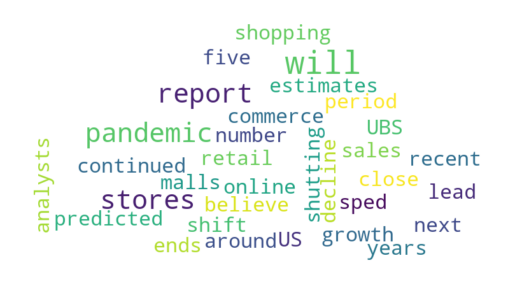

In [ ]:
#@title WORDCLOUD
from PIL import Image
import numpy as np
mask = np.array(Image.open('/content/drive/Shareddrives/[FYP] Fake News Detection/Final/Final_Voting_model_5_dataset/cloud.jpg'))

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white" ,mask=mask,random_state=42, width=mask.shape[1],
               height=mask.shape[0] ).generate(text)  #stopwords
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

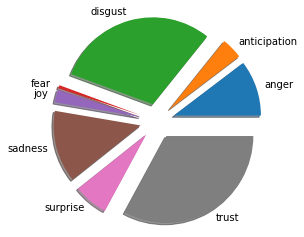

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


em_pie = [abs(p) for p in df[Emotion_features].iloc[0].tolist()]
s =sum(em_pie)
em_pie = [p*100/s for p in em_pie]



y = em_pie
mylabels = Emotion_features
myexplode = [0.2]*len(Emotion_features)

plt.pie(y, labels = mylabels,explode = myexplode, shadow = True)
plt.show() 

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(30,7))
fig.suptitle('Summary Of the prediction', fontsize=16)

# Semantic_features
# Embed_features
# LexMod_Features
# Emotion_features
# -----------------------------------Induvidual Model Support ---------------------------------------------

labels = ['ling', 'lang', 'emo',""]
prob_0=[pred_ling_prob[0][0],pred_lang_prob[0][0],pred_emo_prob[0][0],0]
prob_1=[pred_ling_prob[0][1],pred_lang_prob[0][1],pred_emo_prob[0][1],0]

width = 0.35       # the width of the bars: can also be len(x) sequence

ax=axs[0] 
ax.barh(labels, prob_0, width, label='True')
# ax.barh(labels, prob_1, width, left=prob_0,label='Fake')

ax.set_xlabel('Probablity')
ax.set_ylabel("model")
ax.set_title('Predicted probablity by each model')
ax.legend()


In [ ]:
# For those in #Australia, just in case you’re wondering who owns the milk you drink. China company Mengniu Dairy owns the following brands: Dairy Farmers, Pura, Farmers Union, Masters, Moove, Dare, Vitasoy, Yoplait, Fruche, Divine Classic, YoGo, Big M, Berri, Just Juice, Daily Juice, King Island Dairy, South Cape, Tilba, Timboon, Tasmanian Heritage and Clover Creek,

